In [112]:
import scipy as sc
import scipy.signal
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import *
from keras.initializers import glorot_uniform
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import skimage as ski
import skimage.color
import skimage.io
import random
import os

%matplotlib inline

#### Считываем мета файл

In [2]:
df_meta = pd.read_csv('data/meta/meta.txt', header=None)
df_meta.columns = ['filename', 'type', 'idk', 'duration', 'label']

In [3]:
class_num2str = pd.Series(df_meta.label.unique())
class_str2num = pd.Series(range(0,len(class_num2str)))
class_str2num.index = class_num2str.values

df_meta.label.value_counts()

door             3416
tool             1659
knocking_door    1656
bags             1236
keyboard         1225
background       1126
ring              713
speech            276
Name: label, dtype: int64

#### Функция для обрезки аудио на равные куски и получения их спектрограммы

In [4]:
def crop(wave_data, width, sr):
    cropped = []
    WINDOW_STEP = 128
    if sr == 16000:
        WINDOW_SIZE = 512
        spec = sc.signal.spectrogram(wave_data, fs=sr, window=sc.signal.get_window('hann',WINDOW_SIZE), noverlap=WINDOW_SIZE-WINDOW_STEP)[2]
    else:
        WINDOW_SIZE = 705
        spec = sc.signal.spectrogram(wave_data, fs=sr, window=sc.signal.get_window('hann',WINDOW_SIZE), noverlap=WINDOW_SIZE-WINDOW_STEP)[2]
        spec = spec[:257,:]
        
    spec = np.flipud(np.log10(spec))
    iters = spec.shape[1]/width
    
    if iters < 1:
        n,m = spec.shape[0], width
        tail = np.zeros((n,m)) - abs(spec.min())
        tail[:,:spec.shape[1]] = spec
        cropped.append(tail)
    else:
        for i in range(0,int(iters)):
            cropped.append(spec[:,i*width:(i+1)*width])

        if iters - int(iters) > 0.25:
            n,m = cropped[0].shape
            tail = np.zeros((n,m)) - abs(spec.min())
            tail_spec = spec[:,int(iters)*width:]
            tail[:,:tail_spec.shape[1]] = tail_spec
            cropped.append(tail)
    return cropped

#### Функция для применения crop для всех файлов и сохранение их спектрограммы в виде изображения

In [5]:
def cropping_all(df_meta, read_path='data/audio/', save_path='data/processed_audio/'):
    filenames = []
    labels = []
    counter = 0
    for k, file in enumerate(tqdm_notebook(df_meta.filename)):
        label = df_meta.iloc[k].label
        sr, wave_data = sc.io.wavfile.read(read_path+file)
        cropped_waves = crop(wave_data, width=300, sr=sr)
        for i in range(len(cropped_waves)):
            name = file[:-3] + '__' + str(i)
            counter += 1
            plt.imsave(save_path  + name + '.png', cropped_waves[i], cmap='gray')
            filenames.append(name)
            labels.append(label)
    return filenames, labels, counter

#### Создание мета файла для cropped аудио (по факту для изображений спектрограмм)

In [389]:
# UNCOMMENT THIS IF YOU DONT DOWNLOAD proc_meta.csv

# fn, lb, cnt = cropping_all(df_meta)

# tmp_dict = dict()
# tmp_dict['filename'] = fn
# tmp_dict['label'] = lb

# df_proc_meta = pd.DataFrame.from_dict(tmp_dict)
# df_proc_meta.to_csv('proc_meta.csv', encoding='UTF-8', index=False)

C:\Users\Alexey\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
C:\Users\Alexey\Miniconda3\lib\site-packages\matplotlib\colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\Users\Alexey\Miniconda3\lib\site-packages\numpy\ma\core.py:710: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


In [6]:
df_proc_meta = pd.read_csv('proc_meta.csv')
df_proc_meta['group'] = df_proc_meta.filename.apply(lambda x: str(x).split('.')[0])

#### Создание валидационной и обучающих выборок

In [34]:
np.random.seed(seed)
val_file = df_meta.loc[np.sort(np.random.choice(range(len(df_meta)), size=3000))]
val_file.label.value_counts()

door             882
tool             471
knocking_door    444
keyboard         338
bags             308
background       302
ring             188
speech            67
Name: label, dtype: int64

In [35]:
indexes = []
for file in tqdm_notebook(val_file.filename):
    indexes.extend(df_proc_meta[df_proc_meta.group == file[:-4]].index)

In [36]:
val_data = df_proc_meta.loc[indexes]
train_data = df_proc_meta.loc[np.sort(list(set(range(len(df_proc_meta))) - set(val_data.index)))]

#### Генератор батчей

In [42]:
def user_generator(df, seed, batch_size=64):
    path = './data/processed_audio/'
    n = len(df_proc_meta)
    labels = pd.get_dummies(df_proc_meta.label)
    np.random.seed(seed)
    while 1:
        x = np.zeros((batch_size, 300, 257))
        i = np.random.choice(range(n), batch_size)
        y = labels.loc[i].values
        files = df_proc_meta.loc[i].filename
        for k in range(batch_size):
            img = plt.imread(path+files.iloc[k]+'.png')[:,:,0]
            img = np.rot90(img)
            x[k] = img
        
        yield x, y

#### Архитектура CNN 

In [7]:
BATCH_SIZE = 48
seed=42

input_layer = Input(shape=(300,257))

conv1 = Conv1D(64, 5, padding='same', strides=2, kernel_initializer=glorot_uniform(seed=seed))(input_layer)
relu_1 = Activation('relu')(conv1)
max_pool1 = MaxPooling1D(pool_size=2)(relu_1)

conv2 = Conv1D(64, 5, padding='same', strides=1, kernel_initializer=glorot_uniform(seed=seed+1))(max_pool1)
relu_2 = Activation('relu')(conv2)
max_pool2 = MaxPooling1D(pool_size=2)(relu_2)

conv3 = Conv1D(128, 5, padding='same', strides=1, kernel_initializer=glorot_uniform(seed=seed+2))(max_pool2)
relu_3 = Activation('relu')(conv3)
max_pool3 = MaxPooling1D(pool_size=2)(relu_3)

conv4 = Conv1D(128, 3, padding='same', strides=1, kernel_initializer=glorot_uniform(seed=seed+3))(max_pool3)
relu_4 = Activation('relu')(conv4)
max_pool4 = MaxPooling1D(pool_size=2)(relu_4)

conv5 = Conv1D(256, 3, padding='same', strides=1, kernel_initializer=glorot_uniform(seed=seed+4))(max_pool4)
relu_5 = Activation('relu')(conv5)
max_pool5 = MaxPooling1D(pool_size=2)(relu_5)

flatten = Flatten()(max_pool5)

dense_0 = Dense(1024, activation='sigmoid', kernel_initializer=glorot_uniform(seed=seed+5))(flatten)
dense_out = Dense(8, activation='softmax', kernel_initializer=glorot_uniform(seed=seed+6))(dense_0)

model = Model(inputs=[input_layer], outputs=[dense_out])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 257)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 64)           82304     
_________________________________________________________________
activation_1 (Activation)    (None, 150, 64)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 75, 64)            20544     
_________________________________________________________________
activation_2 (Activation)    (None, 75, 64)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 64)            0         
__________

#### Обучение на 5 эпохах с дефолтным lr

Epoch 1/5


146/600 [======>.......................] - ETA: 20:55 - loss: 2.1954 - categorical_accuracy: 0.145 - ETA: 10:52 - loss: 2.1574 - categorical_accuracy: 0.135 - ETA: 7:32 - loss: 2.1285 - categorical_accuracy: 0.180 - ETA: 5:52 - loss: 2.1699 - categorical_accuracy: 0.17 - ETA: 4:52 - loss: 2.1736 - categorical_accuracy: 0.15 - ETA: 4:12 - loss: 2.1504 - categorical_accuracy: 0.15 - ETA: 3:44 - loss: 2.1441 - categorical_accuracy: 0.16 - ETA: 3:22 - loss: 2.1338 - categorical_accuracy: 0.15 - ETA: 3:09 - loss: 2.1345 - categorical_accuracy: 0.15 - ETA: 3:07 - loss: 2.1348 - categorical_accuracy: 0.15 - ETA: 3:04 - loss: 2.1293 - categorical_accuracy: 0.15 - ETA: 3:03 - loss: 2.1205 - categorical_accuracy: 0.14 - ETA: 3:01 - loss: 2.1045 - categorical_accuracy: 0.15 - ETA: 2:59 - loss: 2.0995 - categorical_accuracy: 0.15 - ETA: 2:58 - loss: 2.1043 - categorical_accuracy: 0.15 - ETA: 2:58 - loss: 2.1048 - categorical_accuracy: 0.15 - ETA: 2:57 - loss: 2.1009 - categorical_accuracy: 0.15 - 

585/600 [============================>.] - ETA: 47s - loss: 1.3880 - categorical_accuracy: 0.481 - ETA: 47s - loss: 1.3865 - categorical_accuracy: 0.481 - ETA: 46s - loss: 1.3864 - categorical_accuracy: 0.481 - ETA: 46s - loss: 1.3856 - categorical_accuracy: 0.482 - ETA: 46s - loss: 1.3847 - categorical_accuracy: 0.482 - ETA: 45s - loss: 1.3838 - categorical_accuracy: 0.482 - ETA: 45s - loss: 1.3834 - categorical_accuracy: 0.483 - ETA: 45s - loss: 1.3830 - categorical_accuracy: 0.483 - ETA: 45s - loss: 1.3824 - categorical_accuracy: 0.483 - ETA: 44s - loss: 1.3807 - categorical_accuracy: 0.484 - ETA: 44s - loss: 1.3799 - categorical_accuracy: 0.484 - ETA: 44s - loss: 1.3792 - categorical_accuracy: 0.485 - ETA: 43s - loss: 1.3787 - categorical_accuracy: 0.485 - ETA: 43s - loss: 1.3776 - categorical_accuracy: 0.485 - ETA: 43s - loss: 1.3764 - categorical_accuracy: 0.486 - ETA: 43s - loss: 1.3750 - categorical_accuracy: 0.486 - ETA: 42s - loss: 1.3737 - categorical_accuracy: 0.487 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 1.2371 - categorical_accuracy: 0.54 - ETA: 3s - loss: 1.2360 - categorical_accuracy: 0.54 - ETA: 3s - loss: 1.2351 - categorical_accuracy: 0.54 - ETA: 3s - loss: 1.2338 - categorical_accuracy: 0.54 - ETA: 2s - loss: 1.2329 - categorical_accuracy: 0.54 - ETA: 2s - loss: 1.2319 - categorical_accuracy: 0.54 - ETA: 2s - loss: 1.2311 - categorical_accuracy: 0.54 - ETA: 2s - loss: 1.2303 - categorical_accuracy: 0.54 - ETA: 1s - loss: 1.2298 - categorical_accuracy: 0.54 - ETA: 1s - loss: 1.2292 - categorical_accuracy: 0.54 - ETA: 1s - loss: 1.2283 - categorical_accuracy: 0.54 - ETA: 0s - loss: 1.2271 - categorical_accuracy: 0.54 - ETA: 0s - loss: 1.2259 - categorical_accuracy: 0.54 - ETA: 0s - loss: 1.2246 - categorical_accuracy: 0.55 - 241s 402ms/step - loss: 1.2240 - categorical_accuracy: 0.5503 - val_loss: 0.6974 - val_categorical_accuracy: 0.7632
Epoch 2/5


146/600 [======>.......................] - ETA: 47s - loss: 0.4897 - categorical_accuracy: 0.833 - ETA: 1:00 - loss: 0.5527 - categorical_accuracy: 0.82 - ETA: 59s - loss: 0.6260 - categorical_accuracy: 0.8056 - ETA: 59s - loss: 0.6236 - categorical_accuracy: 0.802 - ETA: 59s - loss: 0.6213 - categorical_accuracy: 0.804 - ETA: 1:01 - loss: 0.6012 - categorical_accuracy: 0.81 - ETA: 1:00 - loss: 0.6284 - categorical_accuracy: 0.80 - ETA: 1:00 - loss: 0.6593 - categorical_accuracy: 0.78 - ETA: 1:00 - loss: 0.6938 - categorical_accuracy: 0.77 - ETA: 59s - loss: 0.6876 - categorical_accuracy: 0.7792 - ETA: 59s - loss: 0.6838 - categorical_accuracy: 0.780 - ETA: 59s - loss: 0.6667 - categorical_accuracy: 0.786 - ETA: 1:09 - loss: 0.6730 - categorical_accuracy: 0.78 - ETA: 1:18 - loss: 0.6684 - categorical_accuracy: 0.77 - ETA: 1:32 - loss: 0.6654 - categorical_accuracy: 0.77 - ETA: 1:39 - loss: 0.6790 - categorical_accuracy: 0.76 - ETA: 1:48 - loss: 0.6855 - categorical_accuracy: 0.77 - ETA

585/600 [============================>.] - ETA: 50s - loss: 0.6040 - categorical_accuracy: 0.794 - ETA: 50s - loss: 0.6036 - categorical_accuracy: 0.794 - ETA: 50s - loss: 0.6032 - categorical_accuracy: 0.794 - ETA: 49s - loss: 0.6027 - categorical_accuracy: 0.794 - ETA: 49s - loss: 0.6026 - categorical_accuracy: 0.794 - ETA: 49s - loss: 0.6025 - categorical_accuracy: 0.794 - ETA: 48s - loss: 0.6020 - categorical_accuracy: 0.794 - ETA: 48s - loss: 0.6018 - categorical_accuracy: 0.795 - ETA: 48s - loss: 0.6015 - categorical_accuracy: 0.795 - ETA: 47s - loss: 0.6013 - categorical_accuracy: 0.795 - ETA: 47s - loss: 0.6012 - categorical_accuracy: 0.795 - ETA: 47s - loss: 0.6011 - categorical_accuracy: 0.795 - ETA: 46s - loss: 0.6008 - categorical_accuracy: 0.795 - ETA: 46s - loss: 0.6005 - categorical_accuracy: 0.795 - ETA: 46s - loss: 0.6007 - categorical_accuracy: 0.795 - ETA: 45s - loss: 0.6003 - categorical_accuracy: 0.795 - ETA: 45s - loss: 0.5994 - categorical_accuracy: 0.796 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.5696 - categorical_accuracy: 0.80 - ETA: 4s - loss: 0.5698 - categorical_accuracy: 0.80 - ETA: 3s - loss: 0.5699 - categorical_accuracy: 0.80 - ETA: 3s - loss: 0.5695 - categorical_accuracy: 0.80 - ETA: 3s - loss: 0.5692 - categorical_accuracy: 0.80 - ETA: 2s - loss: 0.5692 - categorical_accuracy: 0.80 - ETA: 2s - loss: 0.5692 - categorical_accuracy: 0.80 - ETA: 2s - loss: 0.5693 - categorical_accuracy: 0.80 - ETA: 1s - loss: 0.5690 - categorical_accuracy: 0.80 - ETA: 1s - loss: 0.5690 - categorical_accuracy: 0.80 - ETA: 1s - loss: 0.5688 - categorical_accuracy: 0.80 - ETA: 0s - loss: 0.5688 - categorical_accuracy: 0.80 - ETA: 0s - loss: 0.5686 - categorical_accuracy: 0.80 - ETA: 0s - loss: 0.5695 - categorical_accuracy: 0.80 - 244s 406ms/step - loss: 0.5694 - categorical_accuracy: 0.8062 - val_loss: 0.5281 - val_categorical_accuracy: 0.8177
Epoch 3/5


146/600 [======>.......................] - ETA: 44s - loss: 0.5239 - categorical_accuracy: 0.833 - ETA: 48s - loss: 0.4610 - categorical_accuracy: 0.854 - ETA: 50s - loss: 0.4329 - categorical_accuracy: 0.847 - ETA: 51s - loss: 0.5135 - categorical_accuracy: 0.802 - ETA: 52s - loss: 0.5270 - categorical_accuracy: 0.804 - ETA: 52s - loss: 0.5409 - categorical_accuracy: 0.805 - ETA: 52s - loss: 0.5343 - categorical_accuracy: 0.806 - ETA: 52s - loss: 0.5334 - categorical_accuracy: 0.804 - ETA: 52s - loss: 0.4993 - categorical_accuracy: 0.817 - ETA: 52s - loss: 0.4792 - categorical_accuracy: 0.829 - ETA: 52s - loss: 0.4684 - categorical_accuracy: 0.839 - ETA: 52s - loss: 0.4853 - categorical_accuracy: 0.831 - ETA: 59s - loss: 0.4765 - categorical_accuracy: 0.834 - ETA: 1:06 - loss: 0.4742 - categorical_accuracy: 0.83 - ETA: 1:13 - loss: 0.4595 - categorical_accuracy: 0.84 - ETA: 1:18 - loss: 0.4643 - categorical_accuracy: 0.84 - ETA: 1:24 - loss: 0.4635 - categorical_accuracy: 0.84 - ETA: 

585/600 [============================>.] - ETA: 47s - loss: 0.4234 - categorical_accuracy: 0.858 - ETA: 47s - loss: 0.4230 - categorical_accuracy: 0.858 - ETA: 46s - loss: 0.4227 - categorical_accuracy: 0.858 - ETA: 46s - loss: 0.4227 - categorical_accuracy: 0.858 - ETA: 46s - loss: 0.4226 - categorical_accuracy: 0.858 - ETA: 46s - loss: 0.4221 - categorical_accuracy: 0.858 - ETA: 45s - loss: 0.4216 - categorical_accuracy: 0.858 - ETA: 45s - loss: 0.4214 - categorical_accuracy: 0.858 - ETA: 45s - loss: 0.4212 - categorical_accuracy: 0.858 - ETA: 44s - loss: 0.4208 - categorical_accuracy: 0.859 - ETA: 44s - loss: 0.4205 - categorical_accuracy: 0.859 - ETA: 44s - loss: 0.4205 - categorical_accuracy: 0.859 - ETA: 43s - loss: 0.4201 - categorical_accuracy: 0.859 - ETA: 43s - loss: 0.4198 - categorical_accuracy: 0.859 - ETA: 43s - loss: 0.4198 - categorical_accuracy: 0.859 - ETA: 43s - loss: 0.4194 - categorical_accuracy: 0.859 - ETA: 42s - loss: 0.4193 - categorical_accuracy: 0.859 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.4144 - categorical_accuracy: 0.86 - ETA: 3s - loss: 0.4150 - categorical_accuracy: 0.86 - ETA: 3s - loss: 0.4150 - categorical_accuracy: 0.86 - ETA: 3s - loss: 0.4157 - categorical_accuracy: 0.86 - ETA: 2s - loss: 0.4157 - categorical_accuracy: 0.86 - ETA: 2s - loss: 0.4160 - categorical_accuracy: 0.86 - ETA: 2s - loss: 0.4162 - categorical_accuracy: 0.86 - ETA: 2s - loss: 0.4160 - categorical_accuracy: 0.86 - ETA: 1s - loss: 0.4159 - categorical_accuracy: 0.86 - ETA: 1s - loss: 0.4157 - categorical_accuracy: 0.86 - ETA: 1s - loss: 0.4161 - categorical_accuracy: 0.86 - ETA: 0s - loss: 0.4159 - categorical_accuracy: 0.86 - ETA: 0s - loss: 0.4159 - categorical_accuracy: 0.86 - ETA: 0s - loss: 0.4154 - categorical_accuracy: 0.86 - 233s 388ms/step - loss: 0.4153 - categorical_accuracy: 0.8612 - val_loss: 0.3998 - val_categorical_accuracy: 0.8614
Epoch 4/5


146/600 [======>.......................] - ETA: 40s - loss: 0.4920 - categorical_accuracy: 0.833 - ETA: 45s - loss: 0.5387 - categorical_accuracy: 0.791 - ETA: 47s - loss: 0.5306 - categorical_accuracy: 0.791 - ETA: 48s - loss: 0.5142 - categorical_accuracy: 0.812 - ETA: 48s - loss: 0.4938 - categorical_accuracy: 0.820 - ETA: 48s - loss: 0.4691 - categorical_accuracy: 0.836 - ETA: 48s - loss: 0.4378 - categorical_accuracy: 0.848 - ETA: 48s - loss: 0.4394 - categorical_accuracy: 0.843 - ETA: 48s - loss: 0.4248 - categorical_accuracy: 0.849 - ETA: 48s - loss: 0.4258 - categorical_accuracy: 0.850 - ETA: 48s - loss: 0.4230 - categorical_accuracy: 0.858 - ETA: 48s - loss: 0.4177 - categorical_accuracy: 0.861 - ETA: 51s - loss: 0.4066 - categorical_accuracy: 0.865 - ETA: 59s - loss: 0.4077 - categorical_accuracy: 0.863 - ETA: 1:07 - loss: 0.4187 - categorical_accuracy: 0.86 - ETA: 1:13 - loss: 0.4321 - categorical_accuracy: 0.85 - ETA: 1:18 - loss: 0.4200 - categorical_accuracy: 0.86 - ETA: 

585/600 [============================>.] - ETA: 47s - loss: 0.3557 - categorical_accuracy: 0.879 - ETA: 47s - loss: 0.3555 - categorical_accuracy: 0.879 - ETA: 46s - loss: 0.3554 - categorical_accuracy: 0.879 - ETA: 46s - loss: 0.3552 - categorical_accuracy: 0.879 - ETA: 46s - loss: 0.3556 - categorical_accuracy: 0.879 - ETA: 45s - loss: 0.3553 - categorical_accuracy: 0.879 - ETA: 45s - loss: 0.3555 - categorical_accuracy: 0.879 - ETA: 45s - loss: 0.3553 - categorical_accuracy: 0.879 - ETA: 45s - loss: 0.3551 - categorical_accuracy: 0.879 - ETA: 44s - loss: 0.3550 - categorical_accuracy: 0.879 - ETA: 44s - loss: 0.3552 - categorical_accuracy: 0.879 - ETA: 44s - loss: 0.3549 - categorical_accuracy: 0.879 - ETA: 43s - loss: 0.3543 - categorical_accuracy: 0.879 - ETA: 43s - loss: 0.3541 - categorical_accuracy: 0.879 - ETA: 43s - loss: 0.3544 - categorical_accuracy: 0.879 - ETA: 42s - loss: 0.3547 - categorical_accuracy: 0.879 - ETA: 42s - loss: 0.3548 - categorical_accuracy: 0.879 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.3495 - categorical_accuracy: 0.88 - ETA: 3s - loss: 0.3497 - categorical_accuracy: 0.88 - ETA: 3s - loss: 0.3496 - categorical_accuracy: 0.88 - ETA: 3s - loss: 0.3494 - categorical_accuracy: 0.88 - ETA: 2s - loss: 0.3492 - categorical_accuracy: 0.88 - ETA: 2s - loss: 0.3492 - categorical_accuracy: 0.88 - ETA: 2s - loss: 0.3493 - categorical_accuracy: 0.88 - ETA: 2s - loss: 0.3492 - categorical_accuracy: 0.88 - ETA: 1s - loss: 0.3490 - categorical_accuracy: 0.88 - ETA: 1s - loss: 0.3488 - categorical_accuracy: 0.88 - ETA: 1s - loss: 0.3486 - categorical_accuracy: 0.88 - ETA: 0s - loss: 0.3483 - categorical_accuracy: 0.88 - ETA: 0s - loss: 0.3485 - categorical_accuracy: 0.88 - ETA: 0s - loss: 0.3486 - categorical_accuracy: 0.88 - 241s 402ms/step - loss: 0.3490 - categorical_accuracy: 0.8803 - val_loss: 0.3011 - val_categorical_accuracy: 0.8975
Epoch 5/5


146/600 [======>.......................] - ETA: 41s - loss: 0.2842 - categorical_accuracy: 0.875 - ETA: 45s - loss: 0.3024 - categorical_accuracy: 0.875 - ETA: 47s - loss: 0.3053 - categorical_accuracy: 0.881 - ETA: 47s - loss: 0.3022 - categorical_accuracy: 0.880 - ETA: 48s - loss: 0.3065 - categorical_accuracy: 0.875 - ETA: 48s - loss: 0.3332 - categorical_accuracy: 0.871 - ETA: 48s - loss: 0.3280 - categorical_accuracy: 0.875 - ETA: 49s - loss: 0.3036 - categorical_accuracy: 0.882 - ETA: 49s - loss: 0.3266 - categorical_accuracy: 0.879 - ETA: 48s - loss: 0.3223 - categorical_accuracy: 0.885 - ETA: 48s - loss: 0.3256 - categorical_accuracy: 0.884 - ETA: 48s - loss: 0.3228 - categorical_accuracy: 0.881 - ETA: 50s - loss: 0.3052 - categorical_accuracy: 0.887 - ETA: 58s - loss: 0.3045 - categorical_accuracy: 0.886 - ETA: 1:05 - loss: 0.2988 - categorical_accuracy: 0.88 - ETA: 1:10 - loss: 0.2871 - categorical_accuracy: 0.89 - ETA: 1:16 - loss: 0.2792 - categorical_accuracy: 0.89 - ETA: 

584/600 [============================>.] - ETA: 1:05 - loss: 0.2874 - categorical_accuracy: 0.90 - ETA: 1:04 - loss: 0.2882 - categorical_accuracy: 0.90 - ETA: 1:04 - loss: 0.2876 - categorical_accuracy: 0.90 - ETA: 1:03 - loss: 0.2875 - categorical_accuracy: 0.90 - ETA: 1:03 - loss: 0.2876 - categorical_accuracy: 0.90 - ETA: 1:03 - loss: 0.2876 - categorical_accuracy: 0.90 - ETA: 1:02 - loss: 0.2877 - categorical_accuracy: 0.90 - ETA: 1:02 - loss: 0.2880 - categorical_accuracy: 0.90 - ETA: 1:02 - loss: 0.2880 - categorical_accuracy: 0.90 - ETA: 1:01 - loss: 0.2882 - categorical_accuracy: 0.90 - ETA: 1:01 - loss: 0.2877 - categorical_accuracy: 0.90 - ETA: 1:00 - loss: 0.2881 - categorical_accuracy: 0.90 - ETA: 1:00 - loss: 0.2882 - categorical_accuracy: 0.90 - ETA: 1:00 - loss: 0.2882 - categorical_accuracy: 0.90 - ETA: 59s - loss: 0.2885 - categorical_accuracy: 0.9028 - ETA: 59s - loss: 0.2883 - categorical_accuracy: 0.902 - ETA: 59s - loss: 0.2885 - categorical_accuracy: 0.902 - ETA:

600/600 [==============================] - ETA: 6s - loss: 0.2913 - categorical_accuracy: 0.90 - ETA: 5s - loss: 0.2914 - categorical_accuracy: 0.90 - ETA: 5s - loss: 0.2911 - categorical_accuracy: 0.90 - ETA: 5s - loss: 0.2911 - categorical_accuracy: 0.90 - ETA: 4s - loss: 0.2914 - categorical_accuracy: 0.90 - ETA: 4s - loss: 0.2918 - categorical_accuracy: 0.90 - ETA: 3s - loss: 0.2917 - categorical_accuracy: 0.90 - ETA: 3s - loss: 0.2919 - categorical_accuracy: 0.90 - ETA: 2s - loss: 0.2919 - categorical_accuracy: 0.90 - ETA: 2s - loss: 0.2916 - categorical_accuracy: 0.90 - ETA: 2s - loss: 0.2920 - categorical_accuracy: 0.90 - ETA: 1s - loss: 0.2922 - categorical_accuracy: 0.90 - ETA: 1s - loss: 0.2922 - categorical_accuracy: 0.90 - ETA: 0s - loss: 0.2926 - categorical_accuracy: 0.90 - ETA: 0s - loss: 0.2923 - categorical_accuracy: 0.90 - 326s 543ms/step - loss: 0.2925 - categorical_accuracy: 0.9024 - val_loss: 0.2947 - val_categorical_accuracy: 0.8975


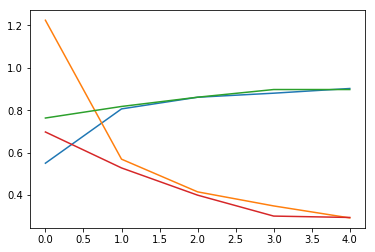

In [46]:
hist1 = model.fit_generator(user_generator(df=train_data, seed=seed, batch_size=BATCH_SIZE), 
                           validation_data=user_generator(df=val_data, seed=seed, batch_size=BATCH_SIZE), 
                           validation_steps=200,steps_per_epoch=600, epochs=5)
plt.plot(hist1.history['categorical_accuracy'])
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_categorical_accuracy'])
plt.plot(hist1.history['val_loss'])

#### Обучение на 5 эпохах с lr 0.0001

Epoch 1/5


146/600 [======>.......................] - ETA: 25:13 - loss: 0.5089 - categorical_accuracy: 0.833 - ETA: 13:00 - loss: 0.4215 - categorical_accuracy: 0.875 - ETA: 8:57 - loss: 0.3494 - categorical_accuracy: 0.881 - ETA: 6:56 - loss: 0.2981 - categorical_accuracy: 0.90 - ETA: 5:43 - loss: 0.2878 - categorical_accuracy: 0.90 - ETA: 4:54 - loss: 0.2800 - categorical_accuracy: 0.91 - ETA: 4:19 - loss: 0.2635 - categorical_accuracy: 0.91 - ETA: 3:53 - loss: 0.2593 - categorical_accuracy: 0.91 - ETA: 3:34 - loss: 0.2863 - categorical_accuracy: 0.90 - ETA: 3:18 - loss: 0.2977 - categorical_accuracy: 0.90 - ETA: 3:11 - loss: 0.2828 - categorical_accuracy: 0.90 - ETA: 3:09 - loss: 0.2697 - categorical_accuracy: 0.91 - ETA: 3:07 - loss: 0.2623 - categorical_accuracy: 0.91 - ETA: 3:06 - loss: 0.2567 - categorical_accuracy: 0.91 - ETA: 3:04 - loss: 0.2567 - categorical_accuracy: 0.92 - ETA: 3:04 - loss: 0.2594 - categorical_accuracy: 0.91 - ETA: 3:03 - loss: 0.2527 - categorical_accuracy: 0.91 - 

585/600 [============================>.] - ETA: 50s - loss: 0.1738 - categorical_accuracy: 0.946 - ETA: 50s - loss: 0.1741 - categorical_accuracy: 0.946 - ETA: 50s - loss: 0.1739 - categorical_accuracy: 0.946 - ETA: 49s - loss: 0.1738 - categorical_accuracy: 0.946 - ETA: 49s - loss: 0.1738 - categorical_accuracy: 0.946 - ETA: 49s - loss: 0.1738 - categorical_accuracy: 0.946 - ETA: 48s - loss: 0.1737 - categorical_accuracy: 0.946 - ETA: 48s - loss: 0.1736 - categorical_accuracy: 0.946 - ETA: 48s - loss: 0.1735 - categorical_accuracy: 0.946 - ETA: 47s - loss: 0.1733 - categorical_accuracy: 0.947 - ETA: 47s - loss: 0.1731 - categorical_accuracy: 0.947 - ETA: 47s - loss: 0.1730 - categorical_accuracy: 0.947 - ETA: 46s - loss: 0.1727 - categorical_accuracy: 0.947 - ETA: 46s - loss: 0.1728 - categorical_accuracy: 0.947 - ETA: 46s - loss: 0.1725 - categorical_accuracy: 0.947 - ETA: 45s - loss: 0.1723 - categorical_accuracy: 0.947 - ETA: 45s - loss: 0.1722 - categorical_accuracy: 0.947 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.1705 - categorical_accuracy: 0.94 - ETA: 4s - loss: 0.1703 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1704 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1704 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1703 - categorical_accuracy: 0.94 - ETA: 2s - loss: 0.1703 - categorical_accuracy: 0.94 - ETA: 2s - loss: 0.1703 - categorical_accuracy: 0.94 - ETA: 2s - loss: 0.1701 - categorical_accuracy: 0.94 - ETA: 1s - loss: 0.1699 - categorical_accuracy: 0.94 - ETA: 1s - loss: 0.1698 - categorical_accuracy: 0.94 - ETA: 1s - loss: 0.1698 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.1698 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.1696 - categorical_accuracy: 0.94 - ETA: 0s - loss: 0.1696 - categorical_accuracy: 0.94 - 251s 419ms/step - loss: 0.1696 - categorical_accuracy: 0.9478 - val_loss: 0.1362 - val_categorical_accuracy: 0.9566
Epoch 2/5


146/600 [======>.......................] - ETA: 45s - loss: 0.1456 - categorical_accuracy: 0.937 - ETA: 48s - loss: 0.1961 - categorical_accuracy: 0.937 - ETA: 50s - loss: 0.1737 - categorical_accuracy: 0.937 - ETA: 51s - loss: 0.1719 - categorical_accuracy: 0.942 - ETA: 52s - loss: 0.1594 - categorical_accuracy: 0.945 - ETA: 53s - loss: 0.1802 - categorical_accuracy: 0.941 - ETA: 54s - loss: 0.1671 - categorical_accuracy: 0.946 - ETA: 54s - loss: 0.1594 - categorical_accuracy: 0.950 - ETA: 54s - loss: 0.1700 - categorical_accuracy: 0.942 - ETA: 54s - loss: 0.1567 - categorical_accuracy: 0.947 - ETA: 53s - loss: 0.1539 - categorical_accuracy: 0.950 - ETA: 53s - loss: 0.1533 - categorical_accuracy: 0.949 - ETA: 1:01 - loss: 0.1476 - categorical_accuracy: 0.95 - ETA: 1:09 - loss: 0.1478 - categorical_accuracy: 0.95 - ETA: 1:17 - loss: 0.1516 - categorical_accuracy: 0.95 - ETA: 1:23 - loss: 0.1477 - categorical_accuracy: 0.95 - ETA: 1:32 - loss: 0.1448 - categorical_accuracy: 0.95 - ETA: 

585/600 [============================>.] - ETA: 48s - loss: 0.1406 - categorical_accuracy: 0.957 - ETA: 47s - loss: 0.1406 - categorical_accuracy: 0.958 - ETA: 47s - loss: 0.1406 - categorical_accuracy: 0.957 - ETA: 47s - loss: 0.1406 - categorical_accuracy: 0.957 - ETA: 47s - loss: 0.1405 - categorical_accuracy: 0.957 - ETA: 46s - loss: 0.1404 - categorical_accuracy: 0.957 - ETA: 46s - loss: 0.1403 - categorical_accuracy: 0.957 - ETA: 46s - loss: 0.1403 - categorical_accuracy: 0.957 - ETA: 45s - loss: 0.1402 - categorical_accuracy: 0.957 - ETA: 45s - loss: 0.1405 - categorical_accuracy: 0.957 - ETA: 45s - loss: 0.1403 - categorical_accuracy: 0.957 - ETA: 44s - loss: 0.1407 - categorical_accuracy: 0.957 - ETA: 44s - loss: 0.1410 - categorical_accuracy: 0.957 - ETA: 44s - loss: 0.1411 - categorical_accuracy: 0.957 - ETA: 44s - loss: 0.1410 - categorical_accuracy: 0.957 - ETA: 43s - loss: 0.1408 - categorical_accuracy: 0.957 - ETA: 43s - loss: 0.1407 - categorical_accuracy: 0.957 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.1412 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1411 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1412 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1412 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1411 - categorical_accuracy: 0.95 - ETA: 2s - loss: 0.1410 - categorical_accuracy: 0.95 - ETA: 2s - loss: 0.1411 - categorical_accuracy: 0.95 - ETA: 2s - loss: 0.1412 - categorical_accuracy: 0.95 - ETA: 1s - loss: 0.1411 - categorical_accuracy: 0.95 - ETA: 1s - loss: 0.1409 - categorical_accuracy: 0.95 - ETA: 1s - loss: 0.1408 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.1408 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.1408 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.1408 - categorical_accuracy: 0.95 - 240s 400ms/step - loss: 0.1406 - categorical_accuracy: 0.9572 - val_loss: 0.1362 - val_categorical_accuracy: 0.9582
Epoch 3/5


146/600 [======>.......................] - ETA: 42s - loss: 0.0560 - categorical_accuracy: 1.000 - ETA: 46s - loss: 0.0711 - categorical_accuracy: 0.989 - ETA: 48s - loss: 0.0930 - categorical_accuracy: 0.965 - ETA: 50s - loss: 0.0979 - categorical_accuracy: 0.968 - ETA: 51s - loss: 0.1282 - categorical_accuracy: 0.966 - ETA: 51s - loss: 0.1305 - categorical_accuracy: 0.965 - ETA: 52s - loss: 0.1248 - categorical_accuracy: 0.970 - ETA: 53s - loss: 0.1143 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.1164 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.1146 - categorical_accuracy: 0.972 - ETA: 53s - loss: 0.1079 - categorical_accuracy: 0.975 - ETA: 53s - loss: 0.1109 - categorical_accuracy: 0.972 - ETA: 1:00 - loss: 0.1142 - categorical_accuracy: 0.96 - ETA: 1:09 - loss: 0.1149 - categorical_accuracy: 0.96 - ETA: 1:16 - loss: 0.1191 - categorical_accuracy: 0.96 - ETA: 1:22 - loss: 0.1133 - categorical_accuracy: 0.96 - ETA: 1:28 - loss: 0.1102 - categorical_accuracy: 0.96 - ETA: 

585/600 [============================>.] - ETA: 49s - loss: 0.1338 - categorical_accuracy: 0.958 - ETA: 49s - loss: 0.1338 - categorical_accuracy: 0.958 - ETA: 48s - loss: 0.1341 - categorical_accuracy: 0.958 - ETA: 48s - loss: 0.1339 - categorical_accuracy: 0.958 - ETA: 48s - loss: 0.1340 - categorical_accuracy: 0.958 - ETA: 47s - loss: 0.1339 - categorical_accuracy: 0.958 - ETA: 47s - loss: 0.1338 - categorical_accuracy: 0.958 - ETA: 47s - loss: 0.1339 - categorical_accuracy: 0.958 - ETA: 47s - loss: 0.1337 - categorical_accuracy: 0.958 - ETA: 46s - loss: 0.1336 - categorical_accuracy: 0.958 - ETA: 46s - loss: 0.1338 - categorical_accuracy: 0.958 - ETA: 46s - loss: 0.1335 - categorical_accuracy: 0.958 - ETA: 45s - loss: 0.1336 - categorical_accuracy: 0.958 - ETA: 45s - loss: 0.1338 - categorical_accuracy: 0.958 - ETA: 45s - loss: 0.1337 - categorical_accuracy: 0.958 - ETA: 44s - loss: 0.1336 - categorical_accuracy: 0.958 - ETA: 44s - loss: 0.1336 - categorical_accuracy: 0.958 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.1326 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1326 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1325 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1328 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1328 - categorical_accuracy: 0.95 - ETA: 2s - loss: 0.1329 - categorical_accuracy: 0.95 - ETA: 2s - loss: 0.1329 - categorical_accuracy: 0.95 - ETA: 2s - loss: 0.1330 - categorical_accuracy: 0.95 - ETA: 1s - loss: 0.1333 - categorical_accuracy: 0.95 - ETA: 1s - loss: 0.1331 - categorical_accuracy: 0.95 - ETA: 1s - loss: 0.1330 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.1332 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.1332 - categorical_accuracy: 0.95 - ETA: 0s - loss: 0.1332 - categorical_accuracy: 0.95 - 239s 398ms/step - loss: 0.1331 - categorical_accuracy: 0.9588 - val_loss: 0.1394 - val_categorical_accuracy: 0.9570
Epoch 4/5


146/600 [======>.......................] - ETA: 49s - loss: 0.1719 - categorical_accuracy: 0.937 - ETA: 51s - loss: 0.1055 - categorical_accuracy: 0.968 - ETA: 51s - loss: 0.0940 - categorical_accuracy: 0.979 - ETA: 52s - loss: 0.1346 - categorical_accuracy: 0.963 - ETA: 52s - loss: 0.1408 - categorical_accuracy: 0.962 - ETA: 52s - loss: 0.1533 - categorical_accuracy: 0.961 - ETA: 53s - loss: 0.1751 - categorical_accuracy: 0.958 - ETA: 53s - loss: 0.1912 - categorical_accuracy: 0.953 - ETA: 52s - loss: 0.1769 - categorical_accuracy: 0.958 - ETA: 52s - loss: 0.1770 - categorical_accuracy: 0.958 - ETA: 52s - loss: 0.1682 - categorical_accuracy: 0.960 - ETA: 52s - loss: 0.1651 - categorical_accuracy: 0.956 - ETA: 59s - loss: 0.1531 - categorical_accuracy: 0.959 - ETA: 1:07 - loss: 0.1511 - categorical_accuracy: 0.96 - ETA: 1:14 - loss: 0.1464 - categorical_accuracy: 0.96 - ETA: 1:20 - loss: 0.1459 - categorical_accuracy: 0.96 - ETA: 1:25 - loss: 0.1414 - categorical_accuracy: 0.96 - ETA: 

585/600 [============================>.] - ETA: 45s - loss: 0.1253 - categorical_accuracy: 0.960 - ETA: 45s - loss: 0.1254 - categorical_accuracy: 0.960 - ETA: 45s - loss: 0.1255 - categorical_accuracy: 0.960 - ETA: 45s - loss: 0.1257 - categorical_accuracy: 0.960 - ETA: 44s - loss: 0.1257 - categorical_accuracy: 0.960 - ETA: 44s - loss: 0.1255 - categorical_accuracy: 0.960 - ETA: 44s - loss: 0.1256 - categorical_accuracy: 0.960 - ETA: 43s - loss: 0.1258 - categorical_accuracy: 0.960 - ETA: 43s - loss: 0.1261 - categorical_accuracy: 0.960 - ETA: 43s - loss: 0.1259 - categorical_accuracy: 0.960 - ETA: 43s - loss: 0.1259 - categorical_accuracy: 0.960 - ETA: 42s - loss: 0.1259 - categorical_accuracy: 0.960 - ETA: 42s - loss: 0.1260 - categorical_accuracy: 0.960 - ETA: 42s - loss: 0.1258 - categorical_accuracy: 0.960 - ETA: 41s - loss: 0.1257 - categorical_accuracy: 0.960 - ETA: 41s - loss: 0.1255 - categorical_accuracy: 0.960 - ETA: 41s - loss: 0.1255 - categorical_accuracy: 0.960 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.1244 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1244 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1242 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1241 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1241 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1242 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1242 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1241 - categorical_accuracy: 0.96 - ETA: 1s - loss: 0.1243 - categorical_accuracy: 0.96 - ETA: 1s - loss: 0.1243 - categorical_accuracy: 0.96 - ETA: 1s - loss: 0.1242 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1241 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1243 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1242 - categorical_accuracy: 0.96 - 228s 380ms/step - loss: 0.1241 - categorical_accuracy: 0.9615 - val_loss: 0.1042 - val_categorical_accuracy: 0.9659
Epoch 5/5


146/600 [======>.......................] - ETA: 45s - loss: 0.0589 - categorical_accuracy: 1.000 - ETA: 52s - loss: 0.0963 - categorical_accuracy: 0.968 - ETA: 52s - loss: 0.0762 - categorical_accuracy: 0.979 - ETA: 52s - loss: 0.0771 - categorical_accuracy: 0.979 - ETA: 53s - loss: 0.0829 - categorical_accuracy: 0.975 - ETA: 53s - loss: 0.0738 - categorical_accuracy: 0.979 - ETA: 53s - loss: 0.1007 - categorical_accuracy: 0.967 - ETA: 53s - loss: 0.1120 - categorical_accuracy: 0.963 - ETA: 53s - loss: 0.1040 - categorical_accuracy: 0.967 - ETA: 53s - loss: 0.0984 - categorical_accuracy: 0.970 - ETA: 52s - loss: 0.0951 - categorical_accuracy: 0.971 - ETA: 52s - loss: 0.0993 - categorical_accuracy: 0.970 - ETA: 58s - loss: 0.0939 - categorical_accuracy: 0.972 - ETA: 1:05 - loss: 0.0912 - categorical_accuracy: 0.97 - ETA: 1:12 - loss: 0.0940 - categorical_accuracy: 0.97 - ETA: 1:18 - loss: 0.0963 - categorical_accuracy: 0.97 - ETA: 1:23 - loss: 0.0969 - categorical_accuracy: 0.97 - ETA: 

585/600 [============================>.] - ETA: 47s - loss: 0.1157 - categorical_accuracy: 0.963 - ETA: 47s - loss: 0.1158 - categorical_accuracy: 0.964 - ETA: 47s - loss: 0.1157 - categorical_accuracy: 0.964 - ETA: 46s - loss: 0.1158 - categorical_accuracy: 0.963 - ETA: 46s - loss: 0.1160 - categorical_accuracy: 0.963 - ETA: 46s - loss: 0.1160 - categorical_accuracy: 0.963 - ETA: 45s - loss: 0.1159 - categorical_accuracy: 0.963 - ETA: 45s - loss: 0.1162 - categorical_accuracy: 0.963 - ETA: 45s - loss: 0.1161 - categorical_accuracy: 0.963 - ETA: 45s - loss: 0.1159 - categorical_accuracy: 0.963 - ETA: 44s - loss: 0.1159 - categorical_accuracy: 0.963 - ETA: 44s - loss: 0.1158 - categorical_accuracy: 0.963 - ETA: 44s - loss: 0.1156 - categorical_accuracy: 0.964 - ETA: 43s - loss: 0.1156 - categorical_accuracy: 0.964 - ETA: 43s - loss: 0.1155 - categorical_accuracy: 0.964 - ETA: 43s - loss: 0.1158 - categorical_accuracy: 0.963 - ETA: 43s - loss: 0.1158 - categorical_accuracy: 0.963 - ETA: 

600/600 [==============================] - ETA: 4s - loss: 0.1142 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.1143 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1145 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1144 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1143 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1145 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1144 - categorical_accuracy: 0.96 - ETA: 2s - loss: 0.1144 - categorical_accuracy: 0.96 - ETA: 1s - loss: 0.1142 - categorical_accuracy: 0.96 - ETA: 1s - loss: 0.1144 - categorical_accuracy: 0.96 - ETA: 1s - loss: 0.1143 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1142 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1141 - categorical_accuracy: 0.96 - ETA: 0s - loss: 0.1141 - categorical_accuracy: 0.96 - 252s 420ms/step - loss: 0.1140 - categorical_accuracy: 0.9647 - val_loss: 0.1103 - val_categorical_accuracy: 0.9645


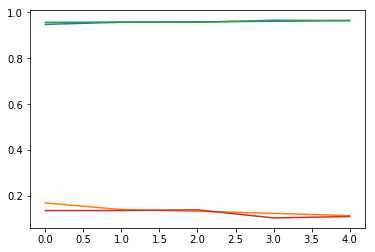

In [73]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
hist11 = model.fit_generator(user_generator(df=train_data, seed=seed+1, batch_size=BATCH_SIZE), 
                           validation_data=user_generator(df=val_data, seed=seed+1, batch_size=BATCH_SIZE), 
                           validation_steps=200,steps_per_epoch=600, epochs=5)
plt.plot(hist11.history['categorical_accuracy'])
plt.plot(hist11.history['loss'])
plt.plot(hist11.history['val_categorical_accuracy'])
plt.plot(hist11.history['val_loss'])

#### Дообучение с очень малым lr

Epoch 1/2


 146/1200 [==>...........................] - ETA: 52:59 - loss: 0.1082 - categorical_accuracy: 0.916 - ETA: 27:03 - loss: 0.2051 - categorical_accuracy: 0.895 - ETA: 18:30 - loss: 0.2037 - categorical_accuracy: 0.916 - ETA: 14:11 - loss: 0.1811 - categorical_accuracy: 0.927 - ETA: 11:38 - loss: 0.1484 - categorical_accuracy: 0.941 - ETA: 9:57 - loss: 0.1391 - categorical_accuracy: 0.944 - ETA: 8:43 - loss: 0.1344 - categorical_accuracy: 0.94 - ETA: 7:49 - loss: 0.1198 - categorical_accuracy: 0.95 - ETA: 7:06 - loss: 0.1121 - categorical_accuracy: 0.95 - ETA: 6:30 - loss: 0.1091 - categorical_accuracy: 0.96 - ETA: 6:02 - loss: 0.1005 - categorical_accuracy: 0.96 - ETA: 5:39 - loss: 0.1095 - categorical_accuracy: 0.96 - ETA: 5:19 - loss: 0.1030 - categorical_accuracy: 0.96 - ETA: 5:02 - loss: 0.1040 - categorical_accuracy: 0.97 - ETA: 4:50 - loss: 0.1009 - categorical_accuracy: 0.97 - ETA: 4:44 - loss: 0.0960 - categorical_accuracy: 0.97 - ETA: 4:39 - loss: 0.0927 - categorical_accuracy:

 584/1200 [=============>................] - ETA: 2:18 - loss: 0.0913 - categorical_accuracy: 0.97 - ETA: 2:18 - loss: 0.0912 - categorical_accuracy: 0.97 - ETA: 2:17 - loss: 0.0911 - categorical_accuracy: 0.97 - ETA: 2:17 - loss: 0.0909 - categorical_accuracy: 0.97 - ETA: 2:17 - loss: 0.0908 - categorical_accuracy: 0.97 - ETA: 2:17 - loss: 0.0907 - categorical_accuracy: 0.97 - ETA: 2:16 - loss: 0.0906 - categorical_accuracy: 0.97 - ETA: 2:16 - loss: 0.0904 - categorical_accuracy: 0.97 - ETA: 2:16 - loss: 0.0903 - categorical_accuracy: 0.97 - ETA: 2:16 - loss: 0.0903 - categorical_accuracy: 0.97 - ETA: 2:16 - loss: 0.0901 - categorical_accuracy: 0.97 - ETA: 2:16 - loss: 0.0901 - categorical_accuracy: 0.97 - ETA: 2:15 - loss: 0.0899 - categorical_accuracy: 0.97 - ETA: 2:15 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 2:15 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 2:15 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 2:15 - loss: 0.0901 - categorical_accuracy: 0.97 - ETA

 730/1200 [=================>............] - ETA: 1:50 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:49 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:49 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:49 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:49 - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 1:49 - loss: 0.0893 - categorical_accuracy: 0.97 - ETA: 1:48 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:48 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:48 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:48 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:48 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:47 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:47 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:47 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:47 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:47 - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 1:46 - loss: 0.0892 - categorical_accuracy: 0.97 - ETA

 876/1200 [====================>.........] - ETA: 1:22 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:22 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:22 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.0898 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:20 - loss: 0.0897 - categorical_accuracy: 0.97 - ETA: 1:20 - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 1:20 - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 1:20 - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 1:20 - loss: 0.0893 - categorical_accuracy: 0.97 - ETA: 1:19 - loss: 0.0893 - categorical_accuracy: 0.97 - ETA: 1:19 - loss: 0.0892 - categorical_accuracy: 0.97 - ETA: 1:19 - loss: 0.0892 - categorical_accuracy: 0.97 - ETA

1022/1200 [========================>.....] - ETA: 56s - loss: 0.0897 - categorical_accuracy: 0.973 - ETA: 55s - loss: 0.0898 - categorical_accuracy: 0.973 - ETA: 55s - loss: 0.0898 - categorical_accuracy: 0.973 - ETA: 55s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 55s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 55s - loss: 0.0899 - categorical_accuracy: 0.972 - ETA: 55s - loss: 0.0898 - categorical_accuracy: 0.973 - ETA: 54s - loss: 0.0898 - categorical_accuracy: 0.972 - ETA: 54s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 54s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 54s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 54s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 53s - loss: 0.0900 - categorical_accuracy: 0.972 - ETA: 53s - loss: 0.0899 - categorical_accuracy: 0.972 - ETA: 53s - loss: 0.0898 - categorical_accuracy: 0.972 - ETA: 53s - loss: 0.0898 - categorical_accuracy: 0.972 - ETA: 53s - loss: 0.0897 - categorical_accuracy: 0.972 - ETA

1169/1200 [============================>.] - ETA: 31s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 31s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 30s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 30s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 30s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 30s - loss: 0.0895 - categorical_accuracy: 0.972 - ETA: 30s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 30s - loss: 0.0893 - categorical_accuracy: 0.972 - ETA: 29s - loss: 0.0895 - categorical_accuracy: 0.972 - ETA: 29s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 29s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 29s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 29s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 28s - loss: 0.0893 - categorical_accuracy: 0.972 - ETA: 28s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 28s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA: 28s - loss: 0.0894 - categorical_accuracy: 0.972 - ETA

1200/1200 [==============================] - ETA: 5s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 5s - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0894 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0896 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0895 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0894 - categorical_

 146/1200 [==>...........................] - ETA: 1:03 - loss: 0.0732 - categorical_accuracy: 1.00 - ETA: 1:12 - loss: 0.1421 - categorical_accuracy: 0.95 - ETA: 1:14 - loss: 0.1301 - categorical_accuracy: 0.95 - ETA: 1:19 - loss: 0.1134 - categorical_accuracy: 0.95 - ETA: 1:18 - loss: 0.0929 - categorical_accuracy: 0.96 - ETA: 1:21 - loss: 0.0908 - categorical_accuracy: 0.97 - ETA: 1:21 - loss: 0.1053 - categorical_accuracy: 0.97 - ETA: 1:23 - loss: 0.1009 - categorical_accuracy: 0.97 - ETA: 1:22 - loss: 0.0917 - categorical_accuracy: 0.97 - ETA: 1:22 - loss: 0.1151 - categorical_accuracy: 0.96 - ETA: 1:22 - loss: 0.1065 - categorical_accuracy: 0.96 - ETA: 1:23 - loss: 0.1017 - categorical_accuracy: 0.96 - ETA: 1:23 - loss: 0.1109 - categorical_accuracy: 0.96 - ETA: 1:26 - loss: 0.1045 - categorical_accuracy: 0.96 - ETA: 1:32 - loss: 0.1003 - categorical_accuracy: 0.96 - ETA: 1:38 - loss: 0.0950 - categorical_accuracy: 0.96 - ETA: 1:45 - loss: 0.1002 - categorical_accuracy: 0.96 - ETA

 584/1200 [=============>................] - ETA: 2:09 - loss: 0.0804 - categorical_accuracy: 0.97 - ETA: 2:09 - loss: 0.0803 - categorical_accuracy: 0.97 - ETA: 2:09 - loss: 0.0807 - categorical_accuracy: 0.97 - ETA: 2:09 - loss: 0.0806 - categorical_accuracy: 0.97 - ETA: 2:09 - loss: 0.0813 - categorical_accuracy: 0.97 - ETA: 2:08 - loss: 0.0816 - categorical_accuracy: 0.97 - ETA: 2:08 - loss: 0.0814 - categorical_accuracy: 0.97 - ETA: 2:08 - loss: 0.0815 - categorical_accuracy: 0.97 - ETA: 2:08 - loss: 0.0814 - categorical_accuracy: 0.97 - ETA: 2:08 - loss: 0.0818 - categorical_accuracy: 0.97 - ETA: 2:07 - loss: 0.0816 - categorical_accuracy: 0.97 - ETA: 2:07 - loss: 0.0815 - categorical_accuracy: 0.97 - ETA: 2:07 - loss: 0.0815 - categorical_accuracy: 0.97 - ETA: 2:07 - loss: 0.0814 - categorical_accuracy: 0.97 - ETA: 2:07 - loss: 0.0820 - categorical_accuracy: 0.97 - ETA: 2:06 - loss: 0.0819 - categorical_accuracy: 0.97 - ETA: 2:06 - loss: 0.0818 - categorical_accuracy: 0.97 - ETA

 730/1200 [=================>............] - ETA: 1:44 - loss: 0.0825 - categorical_accuracy: 0.97 - ETA: 1:43 - loss: 0.0824 - categorical_accuracy: 0.97 - ETA: 1:43 - loss: 0.0824 - categorical_accuracy: 0.97 - ETA: 1:43 - loss: 0.0825 - categorical_accuracy: 0.97 - ETA: 1:43 - loss: 0.0826 - categorical_accuracy: 0.97 - ETA: 1:43 - loss: 0.0827 - categorical_accuracy: 0.97 - ETA: 1:43 - loss: 0.0826 - categorical_accuracy: 0.97 - ETA: 1:42 - loss: 0.0826 - categorical_accuracy: 0.97 - ETA: 1:42 - loss: 0.0824 - categorical_accuracy: 0.97 - ETA: 1:42 - loss: 0.0827 - categorical_accuracy: 0.97 - ETA: 1:42 - loss: 0.0830 - categorical_accuracy: 0.97 - ETA: 1:42 - loss: 0.0829 - categorical_accuracy: 0.97 - ETA: 1:42 - loss: 0.0832 - categorical_accuracy: 0.97 - ETA: 1:41 - loss: 0.0831 - categorical_accuracy: 0.97 - ETA: 1:41 - loss: 0.0830 - categorical_accuracy: 0.97 - ETA: 1:41 - loss: 0.0831 - categorical_accuracy: 0.97 - ETA: 1:41 - loss: 0.0830 - categorical_accuracy: 0.97 - ETA

 876/1200 [====================>.........] - ETA: 1:18 - loss: 0.0828 - categorical_accuracy: 0.97 - ETA: 1:18 - loss: 0.0827 - categorical_accuracy: 0.97 - ETA: 1:18 - loss: 0.0826 - categorical_accuracy: 0.97 - ETA: 1:18 - loss: 0.0826 - categorical_accuracy: 0.97 - ETA: 1:18 - loss: 0.0826 - categorical_accuracy: 0.97 - ETA: 1:18 - loss: 0.0825 - categorical_accuracy: 0.97 - ETA: 1:17 - loss: 0.0825 - categorical_accuracy: 0.97 - ETA: 1:17 - loss: 0.0825 - categorical_accuracy: 0.97 - ETA: 1:17 - loss: 0.0824 - categorical_accuracy: 0.97 - ETA: 1:17 - loss: 0.0823 - categorical_accuracy: 0.97 - ETA: 1:17 - loss: 0.0823 - categorical_accuracy: 0.97 - ETA: 1:17 - loss: 0.0823 - categorical_accuracy: 0.97 - ETA: 1:16 - loss: 0.0827 - categorical_accuracy: 0.97 - ETA: 1:16 - loss: 0.0828 - categorical_accuracy: 0.97 - ETA: 1:16 - loss: 0.0831 - categorical_accuracy: 0.97 - ETA: 1:16 - loss: 0.0832 - categorical_accuracy: 0.97 - ETA: 1:16 - loss: 0.0832 - categorical_accuracy: 0.97 - ETA

1022/1200 [========================>.....] - ETA: 55s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 54s - loss: 0.0843 - categorical_accuracy: 0.974 - ETA: 54s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 54s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 54s - loss: 0.0843 - categorical_accuracy: 0.974 - ETA: 54s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 54s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.0844 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.0843 - categorical_accuracy: 0.974 - ETA: 53s - loss: 0.0843 - categorical_accuracy: 0.974 - ETA: 52s - loss: 0.0842 - categorical_accuracy: 0.974 - ETA: 52s - loss: 0.0842 - categorical_accuracy: 0.974 - ETA: 52s - loss: 0.0841 - categorical_accuracy: 0.974 - ETA: 52s - loss: 0.0842 - categorical_accuracy: 0.974 - ETA: 52s - loss: 0.0841 - categorical_accuracy: 0.974 - ETA

1169/1200 [============================>.] - ETA: 30s - loss: 0.0856 - categorical_accuracy: 0.974 - ETA: 29s - loss: 0.0855 - categorical_accuracy: 0.974 - ETA: 29s - loss: 0.0855 - categorical_accuracy: 0.974 - ETA: 29s - loss: 0.0855 - categorical_accuracy: 0.974 - ETA: 29s - loss: 0.0854 - categorical_accuracy: 0.974 - ETA: 29s - loss: 0.0854 - categorical_accuracy: 0.974 - ETA: 29s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 28s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 28s - loss: 0.0852 - categorical_accuracy: 0.974 - ETA: 28s - loss: 0.0852 - categorical_accuracy: 0.974 - ETA: 28s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 28s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 28s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 27s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 27s - loss: 0.0852 - categorical_accuracy: 0.974 - ETA: 27s - loss: 0.0853 - categorical_accuracy: 0.974 - ETA: 27s - loss: 0.0854 - categorical_accuracy: 0.974 - ETA

1200/1200 [==============================] - ETA: 5s - loss: 0.0849 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0849 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 4s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0847 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0847 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0847 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0846 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0846 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0846 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0847 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0846 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0848 - categorical_accuracy: 0.97 - ETA: 2s - loss: 0.0847 - categorical_

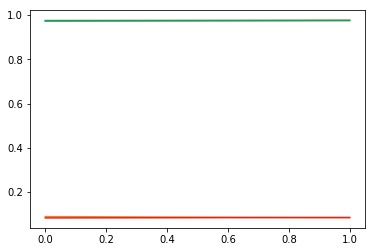

In [82]:
BATCH_SIZE=24
model.compile(optimizer=Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
hist111 = model.fit_generator(user_generator(df=train_data, seed=seed+1, batch_size=BATCH_SIZE), 
                           validation_data=user_generator(df=val_data, seed=seed+1, batch_size=BATCH_SIZE), 
                           validation_steps=400,steps_per_epoch=1200, epochs=2)
plt.plot(hist111.history['categorical_accuracy'])
plt.plot(hist111.history['loss'])
plt.plot(hist111.history['val_categorical_accuracy'])
plt.plot(hist111.history['val_loss'])

#### Сохранение модели

In [89]:
model.save('2to5_1to2epochs.hdf5')

#### --- TEST ---

In [14]:
test_path='./data/test'

In [15]:
test_labels = []
test_files = []
for file in os.listdir(test_path):
    if file.find('unknown') == -1:
        test_files.append(file)
    if file.find('background') == 0:
        test_labels.append(0)
    if file.find('bags') == 0:
        test_labels.append(1)
    if file.find('door') == 0:
        test_labels.append(2)
    if file.find('keyboard') == 0:
        test_labels.append(3)
    if file.find('knocking_door') == 0:
        test_labels.append(4)
    if file.find('ring') == 0:
        test_labels.append(5)
    if file.find('speech') == 0:
        test_labels.append(6)
    if file.find('tool') == 0:
        test_labels.append(7)

In [102]:
temp = dict()
temp['filename'] = test_files[1:]
temp['label'] = test_labels
df_test_meta = pd.DataFrame.from_dict(temp)

#### Обрезание теперь уже тестовых аудио

In [55]:
# UNCOMMENT THIS IF yYOU DONT DOWNLOAD proc_test_meta.csv

#fn, lb, cnt = cropping_all(df_test_meta, read_path='data/test/', save_path='data/processed_test/')

# tmp = dict()
# tmp['filename'] = fn
# tmp['label'] = lb

# df_proc_test_meta = pd.DataFrame.from_dict(tmp)
# df_proc_test_meta.to_csv('proc_test_meta.csv', encoding='UTF-8', index=False)

In [8]:
df_proc_test_meta = pd.read_csv('proc_test_meta.csv')
df_proc_test_meta['group'] = df_proc_test_meta.filename.apply(lambda x: str(x).split('.')[0])

In [9]:
model.load_weights('2to5_1to2epochs.hdf5')

#### Получение спектра из тренировочных данных

In [ ]:
features = np.zeros(shape=(len(df_meta), 8000))

PATH = 'data/audio/'
labels = []
files = []
for i,file in enumerate(tqdm_notebook(df_meta.filename)):
    sr,wave_data = sc.io.wavfile.read(PATH+file)
    spectr = np.abs(np.fft.rfft(wave_data, n=sr))+10
    spectr = spectr[1:]/np.max(spectr[1:])
    labels.append(df_meta.iloc[i].label)
    files.append(df_meta.iloc[i].filename)
    if sr != 16000:
        features[i] = spectr[:8000]
    else:
        features[i] = spectr
    
PATH = 'data/audio/'
data_dict = dict()
for i in tqdm_notebook(range(features.shape[1])):
    data_dict[i] = features[:,i]
    
data_dict['label'] = labels
data_dict['filename'] = files

df_features = pd.DataFrame.from_dict(data_dict)
df_features.label = df_features.label.map(class_str2num)

#### Применение PCA

In [21]:
pca = PCA(n_components=0.9)

In [22]:
%%time
pca.fit(df_features.drop(labels=['label', 'filename'], axis=1))

Wall time: 7min 30s


PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

#### Сохранение модели

In [26]:
with open('pca_params.pkl', 'wb') as handle:
    pickle.dump(pca, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
with open('pca_params.pkl', 'rb') as handle:
    pca = pickle.load(handle)

#### PCA трансформация

In [151]:
df_features_transf = pca.transform(df_features.drop(labels=['label', 'filename'], axis=1))

In [153]:
df_features_transf = (df_features_transf - df_features_transf.min())/(df_features_transf - df_features_transf.min()).max()

#### Получение из CNN "flatten" слоя. (CNN выступает в роли генератора мета-фич)

In [51]:
intermediate_layer_model = Model(inputs=model.layers[0].input,
                                 outputs=model.layers[-2].output)

In [63]:
path = './data/processed_audio/'
train_meta_features = []
files_queue = []
p = np.zeros((1,300,257))
for group in tqdm_notebook(df_proc_meta.group.unique()):
    file_groups = df_proc_meta[df_proc_meta.group == group].filename
    n = len(file_groups)
    pred_file = np.zeros((n,1024))
    for i,file in enumerate(file_groups):
        files_queue.append(file+'.png')
        img = plt.imread(path+file+'.png')[:,:,0]
        img = np.rot90(img)
        p[0] = img
        pred_file[i] = intermediate_layer_model.predict(p)
    train_meta_features.append(pred_file)

Exception in thread Thread-12:
Traceback (most recent call last):
  File "C:\Users\Alexey\Miniconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Alexey\Miniconda3\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Alexey\Miniconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



#### Усредняем мета-фичи обрезков по каждому аудио-файлу

In [64]:
train_mean_meta_features = np.zeros((len(train_meta_features), 1024))
for i in range(len(train_meta_features)):
    train_mean_meta_features[i] = train_meta_features[i].mean(axis=0)

#### Объединяем мета-фичи со спектром, получая новую обучающую выборку

In [156]:
X = np.hstack((df_features_transf,train_mean_meta_features))

In [157]:
y = pd.get_dummies(df_features.label)

In [158]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, random_state=seed)

In [210]:
class_weight = {
    0: 1,
    1: 1,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2
}

#### Обучаем полносвязную сеть

In [211]:
perceptron = Sequential()
perceptron.add(Dense(1024, input_dim=(2064), kernel_initializer=glorot_uniform(seed=seed+6)))
perceptron.add(Activation('sigmoid'))
perceptron.add(Dense(512, kernel_initializer=glorot_uniform(seed=seed+7)))
perceptron.add(Activation('sigmoid'))
perceptron.add(Dense(8, kernel_initializer=glorot_uniform(seed=seed+8)))
perceptron.add(Activation('softmax'))
perceptron.compile(loss='categorical_crossentropy',              
              optimizer=Adam(lr=0.0001),              
              metrics=['categorical_accuracy'])
hist = perceptron.fit(train_X, train_Y, validation_data=(test_X, test_Y), shuffle=True, batch_size=48, 
                      epochs=10, verbose=2, class_weight=class_weight)

Train on 9045 samples, validate on 2262 samples
Epoch 1/10
 - 6s - loss: 0.8768 - categorical_accuracy: 0.7757 - val_loss: 0.2573 - val_categorical_accuracy: 0.9686
Epoch 2/10
 - 4s - loss: 0.1615 - categorical_accuracy: 0.9809 - val_loss: 0.1034 - val_categorical_accuracy: 0.9828
Epoch 3/10
 - 4s - loss: 0.0835 - categorical_accuracy: 0.9866 - val_loss: 0.0700 - val_categorical_accuracy: 0.9850
Epoch 4/10
 - 4s - loss: 0.0600 - categorical_accuracy: 0.9889 - val_loss: 0.0581 - val_categorical_accuracy: 0.9872
Epoch 5/10
 - 4s - loss: 0.0490 - categorical_accuracy: 0.9899 - val_loss: 0.0481 - val_categorical_accuracy: 0.9894
Epoch 6/10
 - 4s - loss: 0.0425 - categorical_accuracy: 0.9918 - val_loss: 0.0438 - val_categorical_accuracy: 0.9898
Epoch 7/10
 - 4s - loss: 0.0380 - categorical_accuracy: 0.9917 - val_loss: 0.0440 - val_categorical_accuracy: 0.9912
Epoch 8/10
 - 4s - loss: 0.0349 - categorical_accuracy: 0.9923 - val_loss: 0.0402 - val_categorical_accuracy: 0.9885
Epoch 9/10
 - 4s

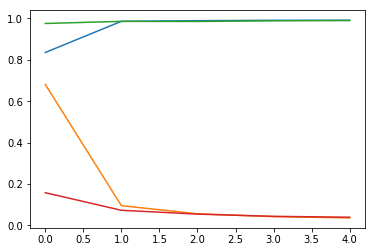

In [160]:
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.plot(hist.history['val_loss'])

### Далее делаем те же самые преобразования для тестовых данных (включая Unknown данные)

In [98]:
path = './data/processed_test/'
test_meta_features = []
files_queue = []
p = np.zeros((1,300,257))
for group in tqdm_notebook(df_proc_test_meta.group.unique()):
    file_groups = df_proc_test_meta[df_proc_test_meta.group == group].filename
    n = len(file_groups)
    pred_file = np.zeros((n,1024))
    for i,file in enumerate(file_groups):
        files_queue.append(file+'.png')
        img = plt.imread(path+file+'.png')[:,:,0]
        img = np.rot90(img)
        p[0] = img
        pred_file[i] = intermediate_layer_model.predict(p)
    test_meta_features.append(pred_file)

In [109]:
test_mean_meta_features = np.zeros((len(test_meta_features), 1024))
for i in range(len(test_meta_features)):
    test_mean_meta_features[i] = test_meta_features[i].mean(axis=0)

In [162]:
features = np.zeros(shape=(len(df_test_meta), 8000))

PATH = 'data/test/'
labels = []
files = []
for i,file in enumerate(tqdm_notebook(df_test_meta.filename)):
    sr,wave_data = sc.io.wavfile.read(PATH+file)
    spectr = np.abs(np.fft.rfft(wave_data, n=sr))+10
    spectr = spectr[1:]/np.max(spectr[1:])
    labels.append(df_test_meta.iloc[i].label)
    files.append(df_test_meta.iloc[i].filename)
    if sr != 16000:
        features[i] = spectr[:8000]
    else:
        features[i] = spectr
    
PATH = 'data/test/'
data_dict = dict()
for i in tqdm_notebook(range(features.shape[1])):
    data_dict[i] = features[:,i]
    
data_dict['label'] = labels
data_dict['filename'] = files

df_test_features = pd.DataFrame.from_dict(data_dict)
df_test_features.label = df_features.label.map(class_str2num)

In [164]:
df_test_features_transf = pca.transform(df_test_features.drop(labels=['label', 'filename'], axis=1))

In [166]:
df_test_features_transf = (df_test_features_transf - df_test_features_transf.min())/(df_test_features_transf - df_test_features_transf.min()).max()

In [167]:
X_TEST = np.hstack((df_test_features_transf, test_mean_meta_features))

In [168]:
Y_TEST = pd.get_dummies(df_test_features.label)

In [212]:
pred = perceptron.predict(X_TEST)

In [213]:
pred.argmax(axis=1)

array([0, 0, 0, 0, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 5, 5, 0, 0, 0, 5, 0, 0, 6, 0, 0, 0, 5, 7, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 2, 1, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2,
       2, 2, 2, 2, 2, 6, 6, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4,
       6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 6, 4, 4, 4, 6, 4, 4, 4, 4, 4,
       4, 4, 5, 4, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 6, 6, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5,
       5, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [214]:
f1_score(df_test_meta.label.values, pred.argmax(axis=1), average=None)

array([0.80519481, 0.91836735, 0.81904762, 0.94736842, 0.89908257,
       0.89041096, 0.93706294, 0.8       ])

In [217]:
f1_score(df_test_meta.label.values, pred.argmax(axis=1), average='macro')

0.8770668321260271

In [230]:
confidence = pred.max(axis=1)

In [231]:
df_pred_test = pd.DataFrame()

In [233]:
df_pred_test['filename'] = df_test_meta.filename
df_pred_test['confidence'] = confidence
df_pred_test['label'] = pred.argmax(axis=1)

In [235]:
df_pred_test.label = df_pred_test.label.map(class_num2str)

In [238]:
df_pred_test.to_csv('result.txt', sep='\t', index=False, encoding='UTF-8', header=False)

In [240]:
test_path = 'data/test/'
unknown_files = []
for file in os.listdir(test_path):
    if file.find('unknown') == 0:
        unknown_files.append(file)

In [250]:
df_unknown_meta = pd.DataFrame(unknown_files, columns=['filename'])
df_unknown_meta['label'] = 0
df_unknown_meta.to_csv('df_unknown_meta.csv', encoding='UTF-8', index=False)

In [253]:
df_unknown_meta = pd.read_csv('df_unknown_meta.csv')

In [254]:
# UNCOMMENT THIS IF yYOU DONT DOWNLOAD proc_test_meta.csv

# fn, lb, cnt = cropping_all(df_unknown_meta, read_path='data/test/', save_path='data/processed_unknown/')

# tmp = dict()
# tmp['filename'] = fn
# tmp['label'] = lb

# df_proc_unknown_meta = pd.DataFrame.from_dict(tmp)
# df_proc_unknown_meta.to_csv('proc_unknown_meta.csv', encoding='UTF-8', index=False)

In [260]:
df_proc_unknown_meta = pd.read_csv('proc_unknown_meta.csv')
df_proc_unknown_meta['group'] = df_proc_unknown_meta.filename.apply(lambda x: str(x).split('.')[0])

In [264]:
path = './data/processed_unknown/'
unknown_meta_features = []
files_queue = []
p = np.zeros((1,300,257))
for group in tqdm_notebook(df_proc_unknown_meta.group.unique()):
    file_groups = df_proc_unknown_meta[df_proc_unknown_meta.group == group].filename
    n = len(file_groups)
    pred_file = np.zeros((n,1024))
    for i,file in enumerate(file_groups):
        files_queue.append(file+'.png')
        img = plt.imread(path+file+'.png')[:,:,0]
        img = np.rot90(img)
        p[0] = img
        pred_file[i] = intermediate_layer_model.predict(p)
    unknown_meta_features.append(pred_file)

In [274]:
unknown_mean_meta_features = np.zeros((len(unknown_meta_features), 1024))
for i in range(len(unknown_meta_features)):
    unknown_mean_meta_features[i] = unknown_meta_features[i].mean(axis=0)

In [268]:
features = np.zeros(shape=(len(df_unknown_meta), 8000))

PATH = 'data/test/'
labels = []
files = []
for i,file in enumerate(tqdm_notebook(df_unknown_meta.filename)):
    sr,wave_data = sc.io.wavfile.read(PATH+file)
    spectr = np.abs(np.fft.rfft(wave_data, n=sr))+10
    spectr = spectr[1:]/np.max(spectr[1:])
    labels.append(df_unknown_meta.iloc[i].label)
    files.append(df_unknown_meta.iloc[i].filename)
    if sr != 16000:
        features[i] = spectr[:8000]
    else:
        features[i] = spectr
    
PATH = 'data/test/'
data_dict = dict()
for i in tqdm_notebook(range(features.shape[1])):
    data_dict[i] = features[:,i]
    
data_dict['label'] = labels
data_dict['filename'] = files

df_unknown_features = pd.DataFrame.from_dict(data_dict)
df_unknown_features.label = df_unknown_features.label.map(class_str2num)

In [271]:
df_unknown_features_transf = pca.transform(df_unknown_features.drop(labels=['filename', 'label'], axis=1))

In [272]:
df_unknown_features_transf = (df_unknown_features_transf - df_unknown_features_transf.min())/(df_unknown_features_transf - df_unknown_features_transf.min()).max()

In [279]:
X_unknown = np.hstack((df_unknown_features_transf, unknown_mean_meta_features))

In [281]:
pred = perceptron.predict(X_unknown)

In [294]:
df_pred_unknown = pd.DataFrame(df_unknown_meta.filename, columns=['filename'])
df_pred_unknown['confidence'] = pred.max(axis=1)
df_pred_unknown['label'] = pred.argmax(axis=1)
df_pred_unknown.label = df_pred_unknown.label.map(class_num2str)

In [295]:
df_pred = pd.concat((df_pred_test, df_pred_unknown))
df_pred.to_csv('result.txt', sep='\t', encoding='UTF-8', index=False, header=False)